In [47]:
import os
import cv2
import pandas as pd
import numpy as np

from keras.models import model_from_json
from keras.models import load_model
from keras.utils import np_utils
from PIL import Image as pil_image
from keras import backend as K

img_size = 48

def load_model_weight(model_name, weight_name = None):
    
    if weight_name ==None:  # which means, model & weight are saved in one file        
        loaded_model = load_model(model_name)
        print('Model & weight are loaded altogether.')
    else:
        with open(model_name, 'r') as m:
            loaded_model_json = m.read()
        loaded_model = model_from_json(loaded_model_json)   # load model architecture from json
        loaded_model.load_weights(weight_name)        
        print('Model & weight are loaded separately.')
    
    return loaded_model      

def grad_cam(model, img, class_idx, layer_idx):
    #img_tensor = np.expand_dims(img, 0)
    #img_arr, img_tensor = preprocess(img_path)
    img_tensor = img
    img_arr = img
    y_c = model.layers[-1].output.op.inputs[0][0, class_idx]  # final layer (before softmax)
    layer_output = model.layers[layer_idx].output  # pick specific layer output (caution: conv layer only)
    
    grad = K.gradients(y_c, layer_output)[0]  # calculate gradient of y_c w.r.t. A_k from the conv layer output
    gradient_fn = K.function([model.input], [layer_output, grad, model.layers[-1].output])
    
    conv_output, grad_val, predictions = gradient_fn([img_tensor])
    conv_output, grad_val = conv_output[0], grad_val[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)
    cam = cv2.resize(cam, (img_size, img_size))
    
    # relu 
    cam = np.maximum(cam, 0)    
    cam = cam / cam.max()
    
    return img_arr, cam, predictions
    
        
def plot_grad_cam(model, img, class_idx, layer_idx = -5):
        
    #img_tensor = np.expand_dims(img, 0)
    #pred_class = np.argmax(model.predict(img))
    
    plt.figure(2)
    fig, axes = plt.subplots(1, 2, figsize=(30, 24))
    img, cam, predictions = grad_cam(model, img, class_idx, layer_idx) #in case of model class, model.model
        
    pred_values = np.squeeze(predictions, 0)
    top1 = np.argmax(pred_values)
    top1_value = np.round(float(pred_values[top1]*100), decimals = 4)
    top4 = np.argpartition(pred_values, -4)[-4:]  #top 4
    
    axes[0, 0].set_title("Pred:{}{}%\n True:{}\n{}".format(class_label[top1], top1_value, class_label[pred_class], top4 ), fontsize=10)
    axes[0, 0].imshow(img,cmap = 'gray')
    axes[0, 1].imshow(img,cmap = 'gray')
    axes[0, 1].imshow(cam, cmap = 'jet', alpha = 0.5)
    

In [49]:
pwd

'F:\\python\\grad_cam-master'

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools  # for confusion matrix plot
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
h='ak_net.h5'
j='ak_net.json'
ak_net = load_model_weight(j,h)

Model & weight are loaded separately.


In [31]:
def preprocess(img_path):
    
    img = pil_image.open(img_path)
    img = img.resize((img_size, img_size))
    img_arr = np.asarray(img) / 255.
    img_tensor = np.expand_dims(img_arr, 0)
    img_tensor = np.expand_dims(img_tensor, 3)    
    
    return img_arr, img_tensor


In [18]:
n_h = '/github/drive_fer/model/models/ak_net_0.h5'
ak_net_0 = load_model_weight(n_h)

Model & weight are loaded altogether.


IndexError: too many indices for array

<Figure size 432x288 with 0 Axes>

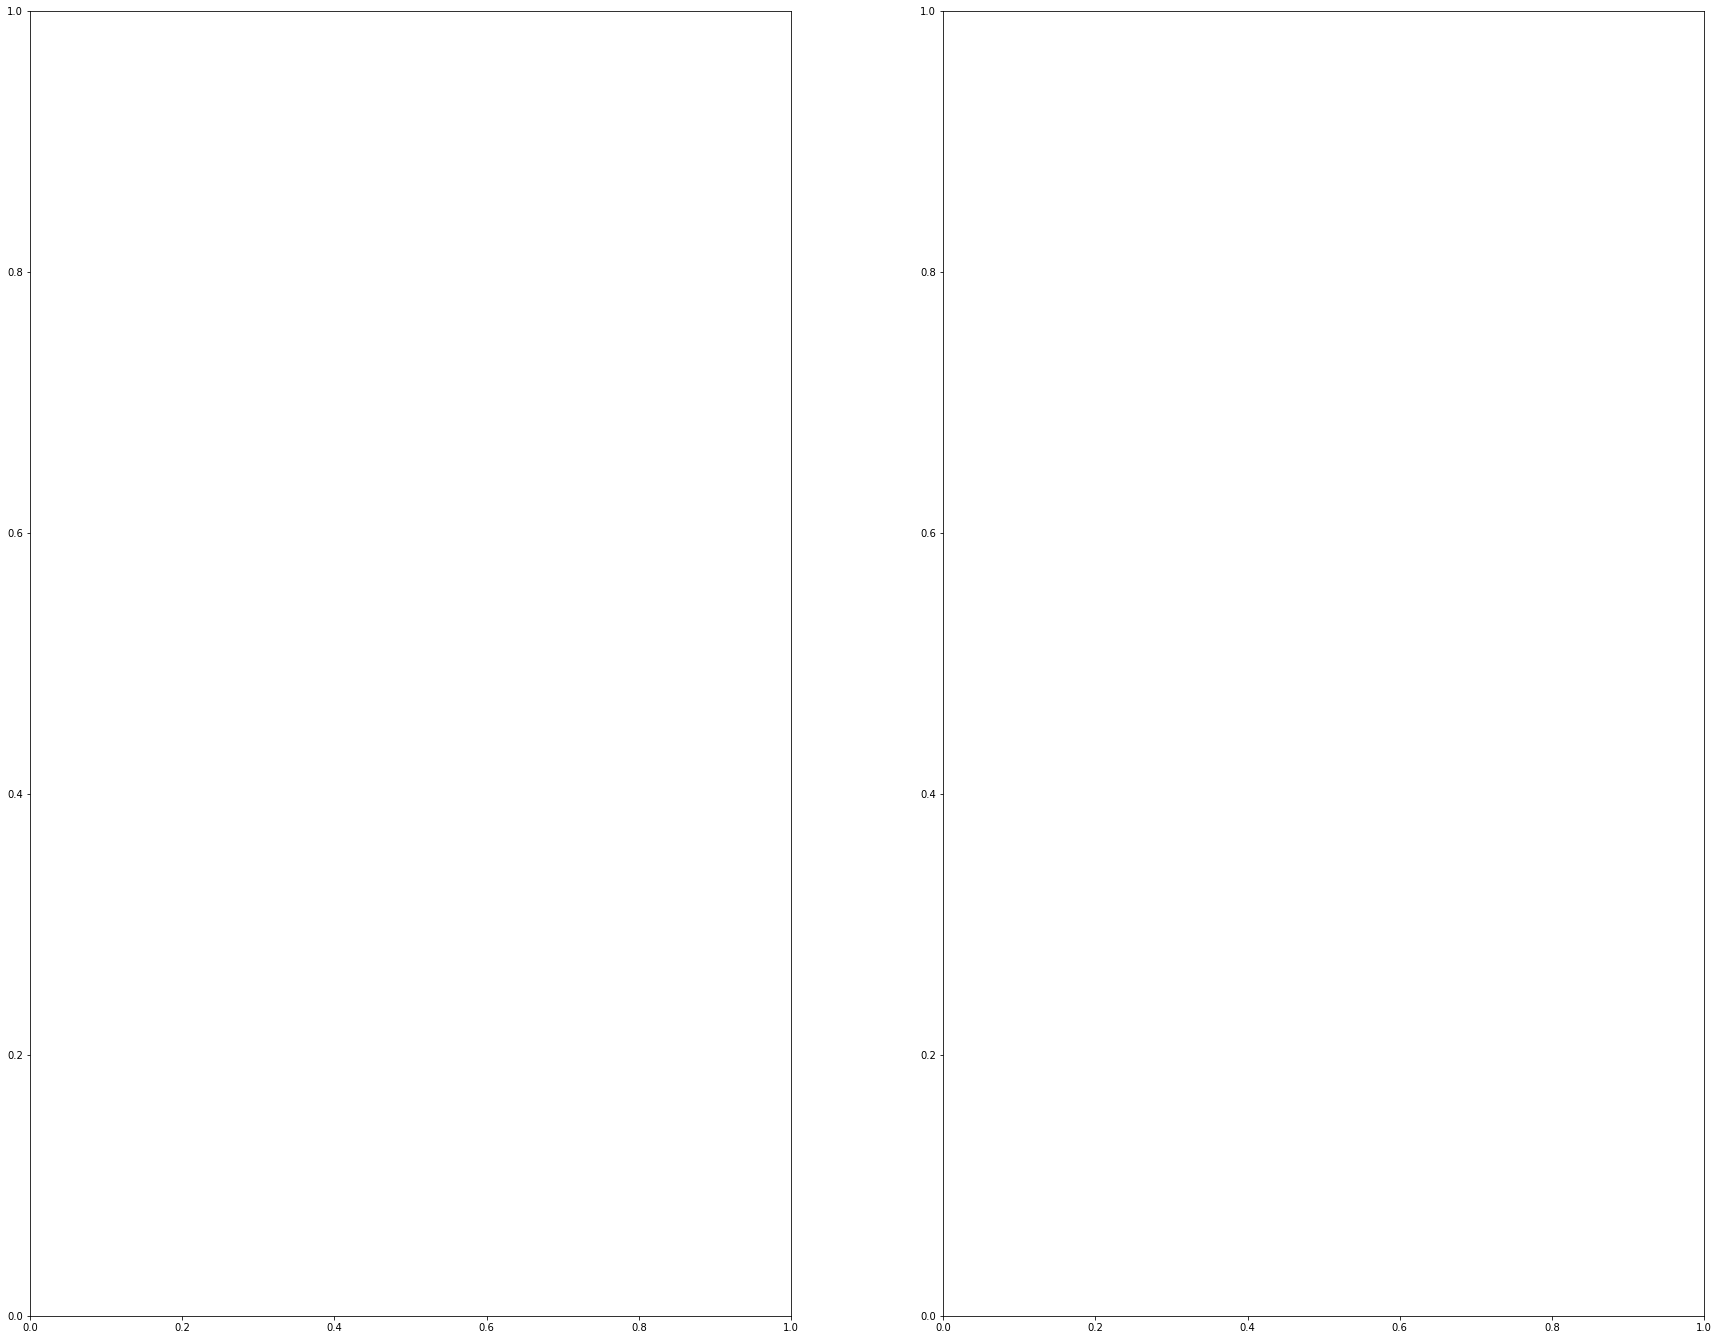

In [48]:

plot_grad_cam(ak_net_0, x_array,0 -4)

In [5]:
### load from npy 
from keras.utils import np_utils
data_loc = '/tmp/face/'
ak_x_train = np.load(data_loc+'x_train_norm.npy')
ak_y_train = np.load(data_loc+'y_train_norm.npy')

ak_x_test = np.load(data_loc+'x_test_norm.npy')
ak_y_test = np.load(data_loc+'y_test_norm.npy')

ak_y_train = np_utils.to_categorical(ak_y_train, 7)
ak_y_test = np_utils.to_categorical(ak_y_test, 7)

In [10]:
class_label = ['angry', 'disgust', 'fear','happy','sad','surprise','neutral']

In [25]:
y = ak_y_train[0]

In [36]:
x_array = np.expand_dims(x, 0)
np.shape(x_array)

(1, 48, 48, 1)

Normalized confusion matrix
[[0.47599165 0.00417537 0.08977035 0.08559499 0.18893528 0.04070981
  0.11482255]
 [0.26126126 0.3963964  0.06306306 0.06306306 0.11711712 0.02702703
  0.07207207]
 [0.13964844 0.00292969 0.33984375 0.09863281 0.19042969 0.12304688
  0.10546875]
 [0.03494927 0.0011274  0.02311161 0.77339346 0.06313416 0.0264938
  0.0777903 ]
 [0.15557338 0.00160385 0.11948677 0.0978348  0.43704892 0.02004812
  0.16840417]
 [0.03128761 0.00120337 0.07701564 0.07701564 0.03971119 0.7400722
  0.03369434]
 [0.1054339  0.         0.0567721  0.12084347 0.18167072 0.01946472
  0.51581509]]


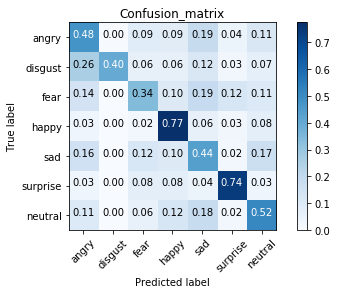

In [14]:
predicted=ak_net_0.predict(ak_x_test)

pred_list = []; actual_list =[]
for i in predicted:
    pred_list.append(np.argmax(i))
for i in ak_y_test:
    actual_list.append(np.argmax(i))

confusion_result = confusion_matrix(actual_list, pred_list)
plot_confusion_matrix(confusion_result, classes=class_label, normalize=True, title='Confusion_matrix')